# Prediction project - Charles PAULAS VICTOR

# 1. Data loading

### Import library

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'test', 'sample_submission', 'train', 'train.csv', 'sample_submission.csv']


In [3]:
# ML libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

### Import dataset

In [4]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

print(f"training set shape : {train.shape}")
print(f"testing set shape : {test.shape}")

training set shape : (1458644, 11)
testing set shape : (625134, 9)


## 2. Data exploration

In [5]:
train.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
test.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [8]:
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## 3. Data processing

### Outliers

In [9]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


We may need to apply scaling to trip_duration

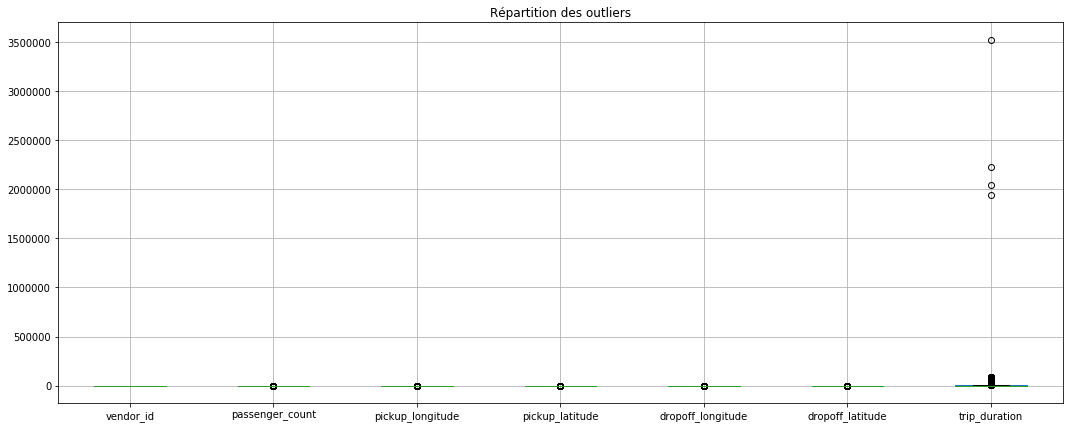

In [10]:
plt.subplots(figsize=(18,7))
plt.title("Répartition des outliers")
train.boxplot();

In [11]:
print(train.loc[train['trip_duration'] > 500000])

               id  vendor_id      ...      store_and_fwd_flag trip_duration
355003  id1864733          1      ...                       N       1939736
680594  id0369307          1      ...                       N       2049578
924150  id1325766          1      ...                       N       2227612
978383  id0053347          1      ...                       N       3526282

[4 rows x 11 columns]


Four entries seems to outlie. Four entries is a very small amount of entries compare to the numbers of entries of the training set (1458644). This means that we can delete this four entries.

In [12]:
print(f"training set shape : {train.shape}")
train = train.loc[train['trip_duration']< 500000]
print(f"training set shape : {train.shape}")

training set shape : (1458644, 11)
training set shape : (1458640, 11)


Check if there is correlation with correlation heatmap

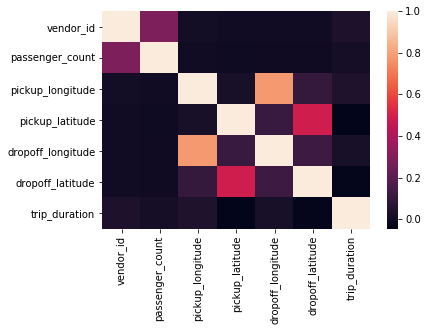

In [13]:
corr = train.corr()
sns.heatmap(corr)

There is not significant correlation

### Categorical data 


In [14]:
le = LabelEncoder()
le.fit(train['store_and_fwd_flag'])
train['store_and_fwd_flag'] = le.transform(train['store_and_fwd_flag'])
test['store_and_fwd_flag'] = le.transform(test['store_and_fwd_flag'])
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435


 ### Transforming data

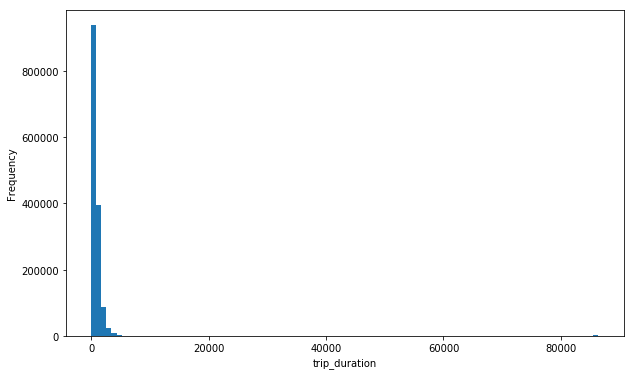

In [15]:
plt.subplots(figsize=(10,6))
plt.hist(train.trip_duration, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('Frequency')
plt.show()

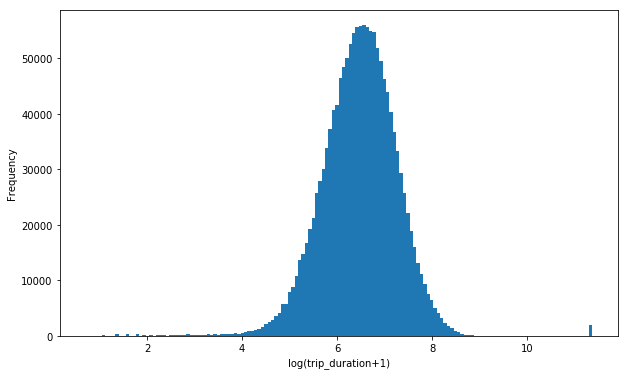

In [16]:
#Log transformation
plt.subplots(figsize=(10,6))
train['trip_duration'] = np.log1p(train['trip_duration'].values) 
plt.hist(train.trip_duration.values, bins=150)
plt.xlabel('log(trip_duration+1)')
plt.ylabel('Frequency')
plt.show()

In this case, the log(1+x) function achieve to retrieve a bell shape distribution from a long train shape distribution. We will make sure to do the "reciprocal function" exp(x)-1 to do the submission

## 4. Feature engineering

### Features extraction

In [17]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

### Features creation 

In [18]:
#### date features
## dates
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['month'] = train['pickup_datetime'].dt.month
train['day'] = train['pickup_datetime'].dt.day
train['weekday'] = train['pickup_datetime'].dt.weekday
train['hour'] = train['pickup_datetime'].dt.hour
train['minute'] = train['pickup_datetime'].dt.minute

test['month'] = test['pickup_datetime'].dt.month
test['day'] = test['pickup_datetime'].dt.day
test['weekday'] = test['pickup_datetime'].dt.weekday
test['hour'] = test['pickup_datetime'].dt.hour
test['minute'] = test['pickup_datetime'].dt.minute

train.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,weekday,hour,minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,6.122493,3,14,0,17,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,6.498282,6,12,6,0,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661527,1,19,1,11,35
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,6.063785,4,6,2,19,32
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,6.077642,3,26,5,13,30


### Features selection

In [19]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'month', 'day', 'weekday', 'hour', 'minute'],
      dtype='object')

In [20]:
selection_train = ["passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","month", "day", "weekday", "hour", "minute"]
selection_test = ["passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude", "month", "day", "weekday", "hour", "minute"]

#selection_train = ["passenger_count","month", "day", "weekday", "hour", "minute"]
#selection_test = ["passenger_count", "month", "day", "weekday", "hour", "minute"]

y_train = train["trip_duration"] # TARGET
X_train = train[selection_train] # FEATURES
X_test = test[selection_test]

Scaling tests

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
X_train.shape, X_test.shape, y_train.shape

((1458640, 10), (625134, 10), (1458640,))

In [23]:
y_train.head(5)

0    6.122493
1    6.498282
2    7.661527
3    6.063785
4    6.077642
Name: trip_duration, dtype: float64

In [24]:
X_train.head(5)

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,day,weekday,hour,minute
0,1,-73.982155,40.767937,-73.964630,40.765602,3,14,0,17,24
1,1,-73.980415,40.738564,-73.999481,40.731152,6,12,6,0,43
2,1,-73.979027,40.763939,-74.005333,40.710087,1,19,1,11,35
3,1,-74.010040,40.719971,-74.012268,40.706718,4,6,2,19,32
4,1,-73.973053,40.793209,-73.972923,40.782520,3,26,5,13,30


In [25]:
X_test.head(5)

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,day,weekday,hour,minute
0,1,-73.988129,40.732029,-73.990173,40.756680,6,30,3,23,59
1,1,-73.964203,40.679993,-73.959808,40.655403,6,30,3,23,59
2,1,-73.997437,40.737583,-73.986160,40.729523,6,30,3,23,59
3,1,-73.956070,40.771900,-73.986427,40.730469,6,30,3,23,59
4,1,-73.970215,40.761475,-73.961510,40.755890,6,30,3,23,59


## 5. Validation

In [26]:
m1 = RandomForestRegressor()
#m1_scaled = RandomForestRegressor()

In [27]:
#print("Start cross validation ...")
#m1_scores = cross_val_score(m1, X_train, y_train, cv=5, scoring ="neg_mean_squared_log_error")
#m1_scores = cross_val_score(m1_scaled, X_train, y_train, cv=5, scoring ="neg_mean_squared_log_error")

In [28]:
#for i in range(len(m1_scores)):
#    m1_scores[i] = np.sqrt(abs(m1_scores[i]))
#print(m1_scores)
#pd.DataFrame(m1_scores).mean(), pd.DataFrame(m1_scores).std()


## 7. Training

In [29]:
print("Start Training ...")
m1.fit(X_train, y_train)
#m1_scaled.fit(X_train_scaled, y_train)

Start Training ...


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## 8. Predictions

In [30]:
y_pred = m1.predict(X_test)
#y_pred_scaled = m1_scaled.predict(X_test_scaled)

## Export model

In [31]:
from sklearn.externals import joblib

# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(m1, filename)

"""
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, Y_test)
print(result)
"""

'\n# load the model from disk\nloaded_model = joblib.load(filename)\nresult = loaded_model.score(X_test, Y_test)\nprint(result)\n'

In [32]:
!ls

__notebook_source__.ipynb  finalized_model.sav


## 9. Submit

In [33]:
#my_submission = pd.DataFrame({'id': test.id, 'trip_duration': y_pred})
#my_submission = pd.DataFrame({'id': test.id, 'trip_duration': y_pred_scaled})
my_submission = pd.DataFrame({'id': test.id, 'trip_duration': np.expm1(y_pred)})


my_submission.head()

,id,trip_duration
0,id3004672,704.925942
1,id3505355,657.333563
2,id1217141,459.039710
3,id2150126,1750.282610
4,id1598245,349.597617


In [34]:
my_submission.to_csv('submission.csv', index=False)
print("Submission done !")

Submission done !


Thanks
- Categorical feature handling with Label Encoder method // Danijel Kivaranovic https://www.kaggle.com/danijelk